<a href="https://colab.research.google.com/github/kfir1g/AI-Project/blob/master/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Initialize tensorflow-GPU

In [2]:
!pip install tensorflow-gpu
import tensorflow as tf 
#test111

     |████████████████████████████████| 377.0MB 67kB/s 


##This part makes sure that we are working on GPU in runtime

In [3]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at : {}'.format(device_name))  

Found GPU at : /device:GPU:0


#Data Preprocessing

##importing Libraries and Data

##Import the data
data is the results of each tree on each line of the testing data + the actual value

In [0]:
import numpy as np
import pandas as pd
# dataset = pd.read_csv("/content/gdrive/My Drive/AI_project/Data/testing_by_tree_1_all.csv")
dataset = pd.read_csv("/content/gdrive/My Drive/AI_project/All_trees_with_random_forst.csv")
# dataset = pd.read_csv("/content/gdrive/My Drive/AIProj/test.csv")
dataset = dataset.fillna(value=-32)


#Getting new array for predection

In [0]:
import numpy as np
import pandas as pd

Sepdataset = pd.read_csv("/content/gdrive/My Drive/AIProj/All_trees_with_random_forest_September.csv")
Sepdataset = Sepdataset.fillna(value = -32) 
# Sepdataset.head(1)

In [0]:
X = Sepdataset.iloc[:,0:-1].values 

In [0]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

(10816, 40)

##Getting the dependent and independent variables

splits the information to results from tree and actual result

In [0]:
X = dataset.iloc[:,1:-1].values 
y = dataset.iloc[:,-1].values
myMin = -25
y = y + myMin*-1 +1
#X = X + myMin*-1 + 1

In [0]:
MAX_PICKUP_BIKES = y.max() + 1 
NUM_OF_INPUTS = X.shape[1]
MAX_PICKUP_BIKES = 58
SHIFT = 26  # the min we decided + 1 

##Splitting the dataset into training set and Test set 

Splits the information to training and test for the NN, test_size can be changed

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

##Random forest file split

In [0]:
X_train = X_train[:,0:-1]
test_random_forest = X_test[:,-1]
X_test = X_test[:,0:-1]

##Feature scaling - not needed for trees

In [0]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_Y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)



#Builed the NN

##Parameters for NN
softmax - output neuron that got the highest value
Epoch - how many time will go over all the data
Batch_size - update weights every batch inputs
Can add more layers or change the numbers

In [0]:
FIRST_LAYAR = 100
SECONED_LAYAR = 60
OUTPUT_ACTIVATION_FUNC = 'softmax'
OPTIMIZER = 'adam' #'sgd'# 'adam' #'rmsprop' #stochastich gradient descent
NUM_EPOCH = 100
BATCH_SIZE = 60

First layer has to have num_of_inputs
Last layer has to have that activation
We can add more layers, by copying the add option and changing options

first run : 
FIRST_LAYAR = 100
SECONED_LAYAR = 60
OUTPUT_ACTIVATION_FUNC = 'softmax'
OPTIMIZER = 'adam' #'sgd'# 'adam' #'rmsprop' #stochastich gradient descent
NUM_EPOCH = 100
BATCH_SIZE = 60

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
classifier = Sequential()

classifier.add(Dense(output_dim = FIRST_LAYAR  , init = 'uniform', activation = 'tanh', input_dim = NUM_OF_INPUTS))
classifier.add(Dense(output_dim = SECONED_LAYAR, init = 'uniform', activation = 'tanh' ))
classifier.add(Dense(output_dim = MAX_PICKUP_BIKES, init = 'uniform', activation = OUTPUT_ACTIVATION_FUNC ))

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
classifier = Sequential()

classifier.add(Dense(output_dim = FIRST_LAYAR  , init = 'uniform', activation = 'tanh', input_dim = NUM_OF_INPUTS))
classifier.add(Dense(output_dim = SECONED_LAYAR, init = 'uniform', activation = 'tanh' ))
classifier.add(Dense(output_dim = MAX_PICKUP_BIKES, init = 'uniform', activation = OUTPUT_ACTIVATION_FUNC ))
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", input_dim=40, units=100, kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", units=60, kernel_initializer="uniform")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=58, kernel_initializer="uniform")`
  


#Define Optimizer and Loss function 

Change the values to change the NN

In [0]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay= 0, momentum=0.9, nesterov=True) #1e-6
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rms = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
classifier.compile(optimizer = OPTIMIZER , loss = 'sparse_categorical_crossentropy',metrics = ['accuracy']) 

#Train the data 

fit is the training, after that saves the weights

In [0]:
classifier.fit(X_train, Y_train, batch_size = BATCH_SIZE , nb_epoch = NUM_EPOCH)
from keras.models import load_model
classifier.save_weights('/content/gdrive/My Drive/AIProj/my_model_weights.h5')

#Load Wights 
To Load wights you need to create the model again and use the classifier to predict  - need to be tested

In [0]:

MAX_PICKUP_BIKES = 58 # y.max() +1 #Todo: check what is the max number
NUM_OF_INPUTS = X_test.shape[1]
FIRST_LAYAR = 100
SECONED_LAYAR = 60
OUTPUT_ACTIVATION_FUNC = 'softmax'
OPTIMIZER = 'adam' #'adam' #stochastich gradient descent
NUM_EPOCH = 100
BATCH_SIZE = 60

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
classifier = Sequential()

classifier.add(Dense(output_dim = FIRST_LAYAR  , init = 'uniform',activation ='tanh',input_dim = NUM_OF_INPUTS ))
classifier.add(Dense(output_dim = SECONED_LAYAR, init = 'uniform', activation = 'tanh' ))
classifier.add(Dense(output_dim = MAX_PICKUP_BIKES, init = 'uniform', activation = OUTPUT_ACTIVATION_FUNC ))
classifier.load_weights('/content/gdrive/My Drive/AI_project/Copy of my_model_weights.h5')

#How to predict one input: 

#input_vector = #put input vector you want to test
#Y_pred = classifier.predict(input_vector)
#pickup_predection = Y_pred[0].argmax()


#Extract the predctions 


1.   getting the predection from the classifier
2.   extracting the argmax which is the number of picups fo reach input
3.  checking while using the test vector our results




##Get predction for new matrix

In [0]:
Y_pred = classifier.predict(X_test)
Y_get = []
for i in range(len(Y_pred)):
  Y_get.append(Y_pred[i].argmax() - SHIFT)

##adding the vector predction to the file

In [0]:
# np.array(Y_get)
Sepdataset["demand"] = Y_get
Sepdataset.to_csv("/content/gdrive/My Drive/AIProj/Final.csv")
# Sepdataset.head(5)

##Extract results for our training 

In [0]:
Y_pred = classifier.predict(X_test)
Y_get = []
for i in range(len(Y_pred)):
  Y_get.append(Y_pred[i].argmax())
  

In [21]:
total = 0 
correct = 0 
wrong = 0 
histo_pred = []
for i in range(len(Y_pred)):
  total = total +1
  if(Y_get[i] == Y_test[i]):
     correct = correct + 1
  else:
    histo_pred.append(abs(Y_get[i] - Y_test[i] ))
    wrong = wrong + 1

    
print("Total "+ str(total) )
print("Correct " + str(correct))
print("Wrong " + str(wrong))
print("acc:" + str(float(correct)/total) )
print(max(histo_pred))    

Total 246119
Correct 170084
Wrong 76035
acc:0.6910640787586493
22


##Histogram for out test prediction

<BarContainer object of 20 artists>

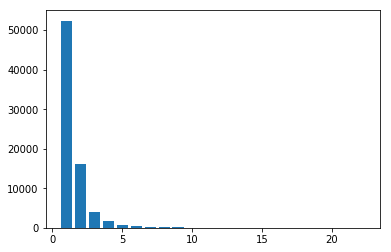

In [24]:
import matplotlib.pyplot as plt

hist = pd.Series(histo_pred).value_counts()
plt.bar(x=hist.index, height=hist)

##Extract results for random forest

In [25]:
total = 0 
correct = 0 
wrong = 0 
histo_random_forest = []
for i in range(len(test_random_forest)):
  total = total +1
  if(test_random_forest[i] == Y_test[i]):
     correct = correct + 1
  else:
    histo_random_forest.append(abs(test_random_forest[i] - Y_test[i] ))
    wrong = wrong + 1

    
print("Total "+ str(total) )
print("Correct " + str(correct))
print("Wrong " + str(wrong))
print("acc:" + str(float(correct)/total) )
print(max(histo_random_forest))    

Total 246119
Correct 7710
Wrong 238409
acc:0.031326309630707094
42.0


##Histogram for random_forest

<BarContainer object of 36 artists>

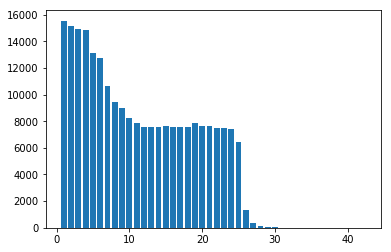

In [26]:
hist = pd.Series(histo_random_forest).value_counts()
plt.bar(x=hist.index, height=hist)

#Evaluating the ANN 

##Using K-Fold Cross Validation 
The main idea is dividing to 10 folds and taking the mean and variance, the mean is the actual result of our ANN and the variance will indicate if we are overfitting
NN needs to be the same as before

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
def build_classifier():
  classifier = Sequential()

  classifier.add(Dense(output_dim = FIRST_LAYAR  , init = 'uniform',activation ='tanh',input_dim = NUM_OF_INPUTS ))
  classifier.add(Dense(output_dim = SECONED_LAYAR, init = 'uniform', activation = 'tanh' ))
  classifier.add(Dense(output_dim = MAX_PICKUP_BIKES, init = 'uniform', activation = OUTPUT_ACTIVATION_FUNC ))
  classifier.compile(optimizer = 'adam'  , loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
  return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size = BATCH_SIZE, nb_epoch = NUM_EPOCH  )
accuracies = cross_val_score(estimator = classifier, X = X_train, y = Y_train, cv =10, n_jobs = -1)# cv num of folds , n_jobs =-1 usingall the GPU
#Accuracies is a vector with all the #folds results(in our case 10) 
#The real Result is the mean of this vector, also we need to check for hight or low variance to know if our results are good
mean = accuracies.mean()
variance = accuracies.std()
variance, mean
  

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


(0.002268920817533607, 0.6896752746592789)

In [0]:
mean

0.32813215512885086

#Improving the ANN

##Droput Regularization to reduce overfitting if needed 
While Getting big variance, meaning the model was doing well on some and than really bad on others, so he is overfitting on the training.
This startagy will help fixing it. 

##Tuning The ANN - choose the best param from all the options


In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer,first, seconed ):
  classifier = Sequential()

  classifier.add(Dense(output_dim = first  , init = 'uniform',activation ='tanh',input_dim = NUM_OF_INPUTS ))
  classifier.add(Dense(output_dim = seconed, init = 'uniform', activation = 'tanh' ))
  classifier.add(Dense(output_dim = MAX_PICKUP_BIKES, init = 'uniform', activation = OUTPUT_ACTIVATION_FUNC ))
  classifier.compile(optimizer = optimizer  , loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
  return classifier

classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 50,75, 150 ],'epochs': [25], 'optimizer' : ['adam', 'rmsprop','sgd'], 'first': [100,200], 'seconed':[100,200]}
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 10)  
grid_serach = grid_search.fit(X_train, Y_train)                     
best_parameters = grid_serach.best_params_
best_accuracy = grid_search.best_score_
best_parameters, best_accuracy

Using TensorFlow backend.


NameError: ignored

In [0]:
best_parameters

NameError: ignored